# Tutorial 1: CommonRoad-io
## Reading, Modifying, and Writing Common Scenarios

This tutorial shows how CommonRoad XML-files can be read, modified, visualized, and stored. To start with, a CommonRoad XML-file consists of a **Scenario** and a **PlanningProblemSet**:
* A **Scenario** represents the environment including a **LaneletNetwork** and a set of **DynamicObstacle** and **StaticObstacle**.
    * A **LaneletNetwork** is built from lane segments (**Lanelet**), that can be connected arbitrarily.
* A **PlanningProblemSet** contains one **PlanningProblem** for every ego vehicle in the **Scenario**, consisting of an **initial position** and a **GoalRegion** that has to be reached.

## 0. Preparation
* Before you proceed any further, make sure you have skimmed through [CommonRoad API](https://commonroad-io.readthedocs.io/en/latest/api/) to gain an overall view of the functionalities provided by CommonRoad modules. You may need to refer to it for implementation details throughout this tutorial.

* Additional documentations on **CommonRoad XML format, Cost Functions, Vehicle Models, etc.** can be found at [CommonRoad](https://commonroad.in.tum.de/) on the specific tool pages.

## 1. Read XML file

As documented in [CommonRoadFileReader](https://commonroad-io.readthedocs.io/en/latest/api/common/#module-commonroad.common.file_reader), the **CommonRoadFileReader** reads in a CommonRoad XML file, and its **open()** method returns a **Scenario** and a **PlanningProblemSet** object:

/home/luis/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


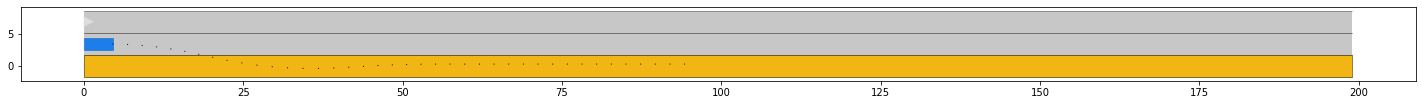

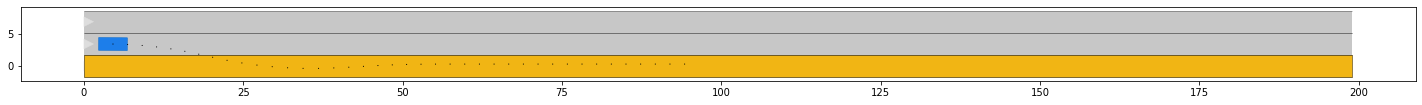

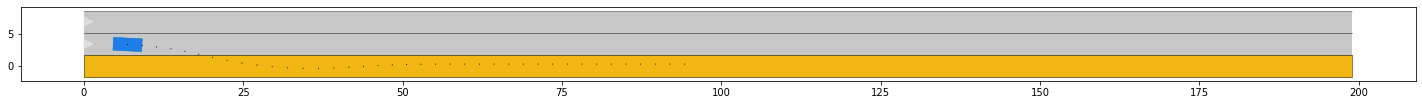

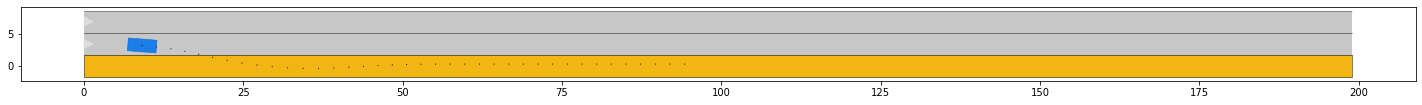

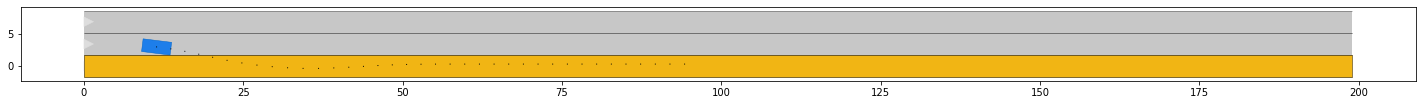

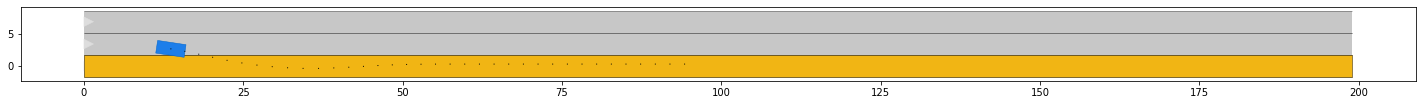

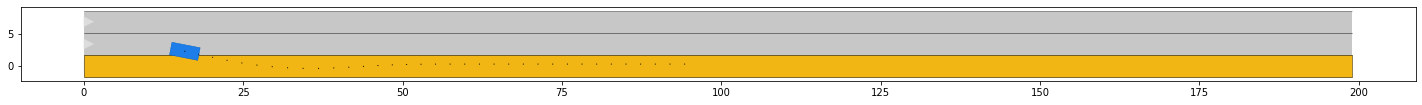

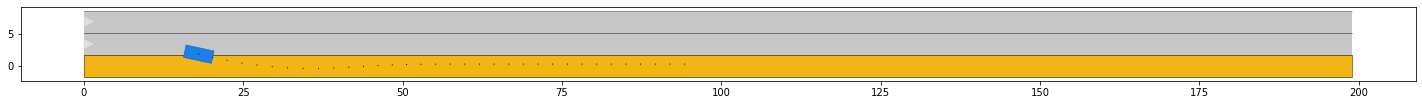

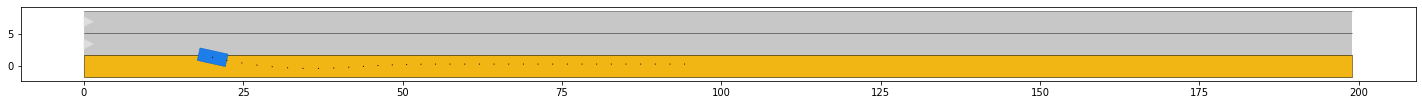

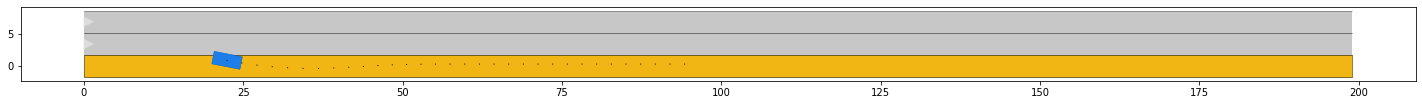

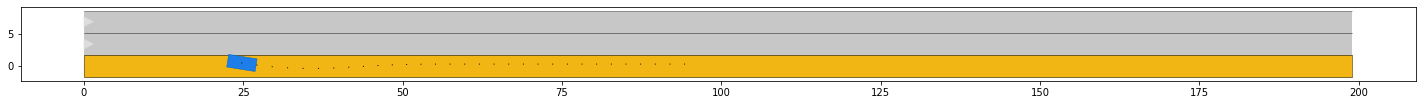

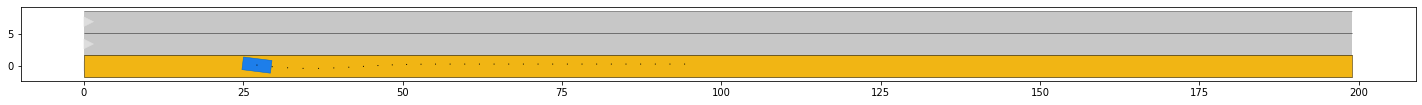

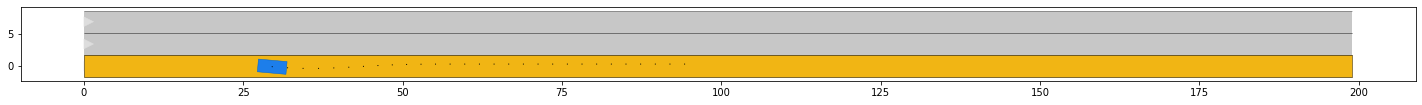

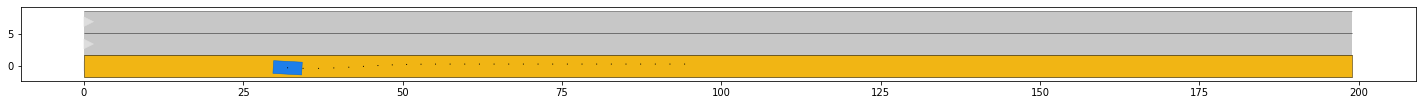

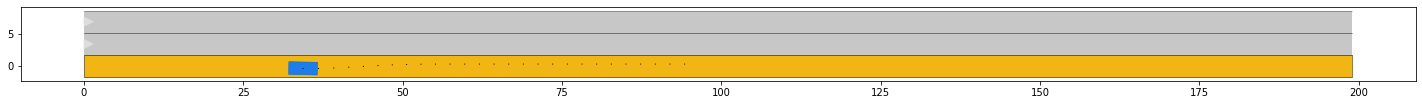

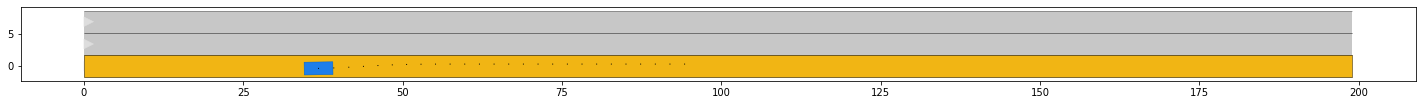

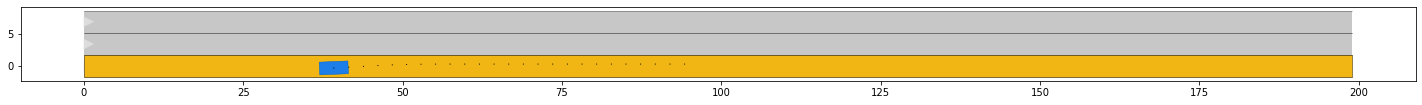

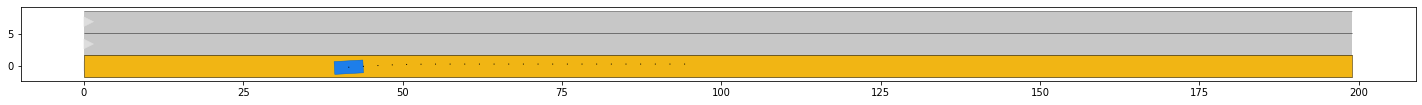

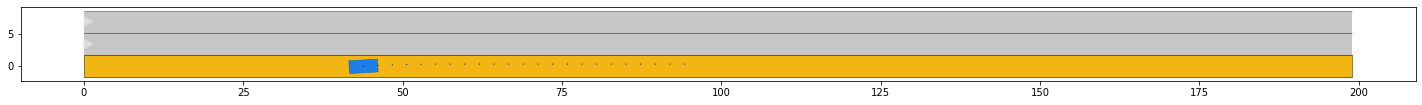

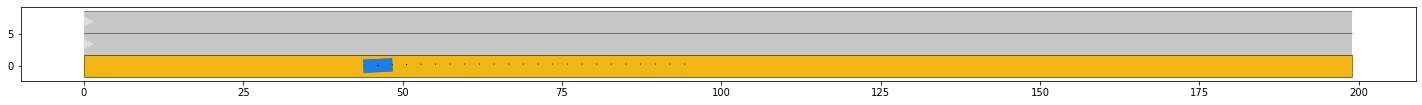

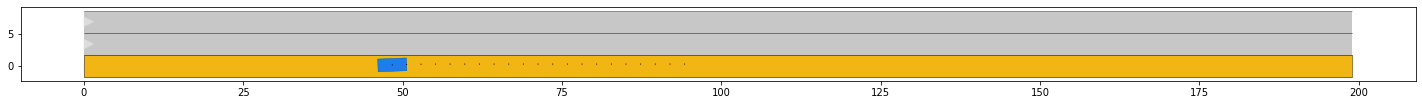

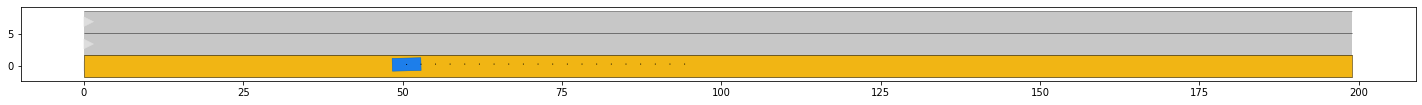

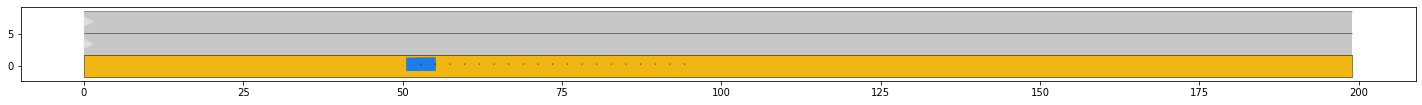

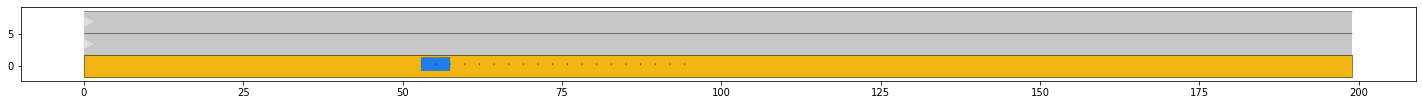

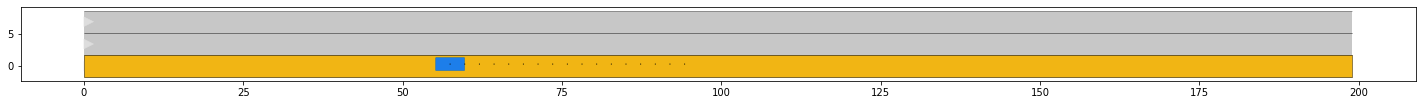

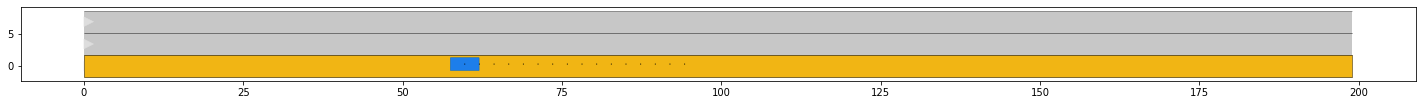

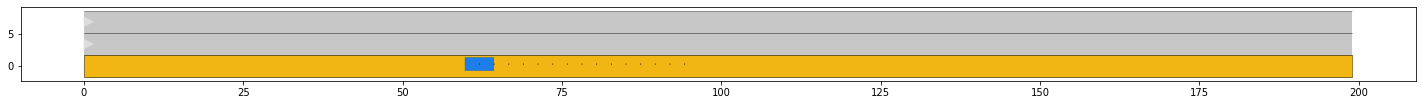

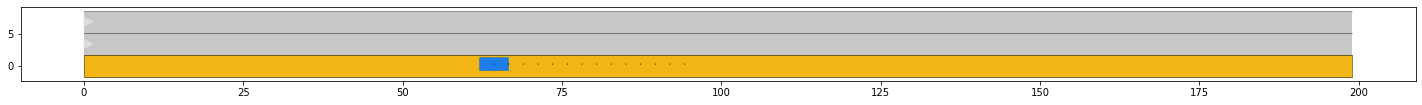

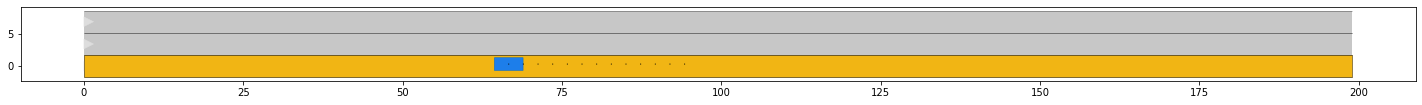

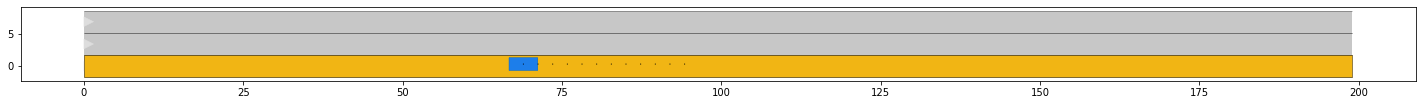

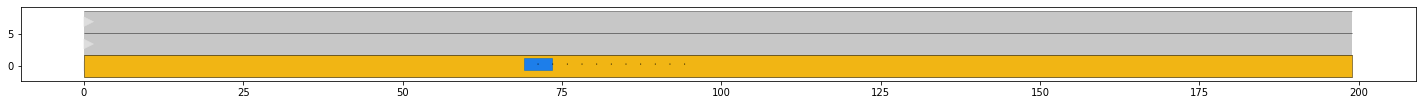

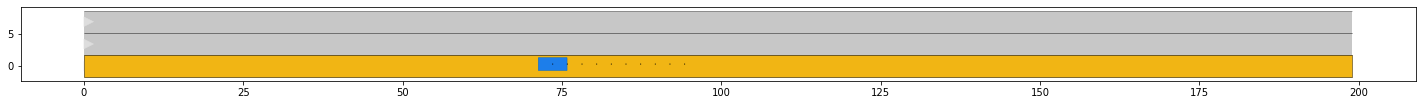

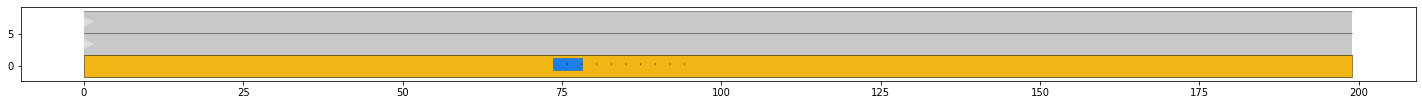

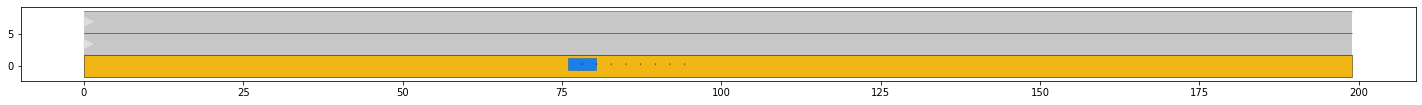

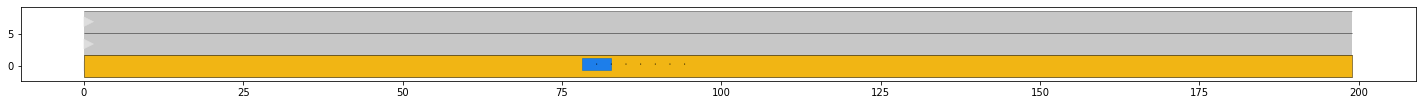

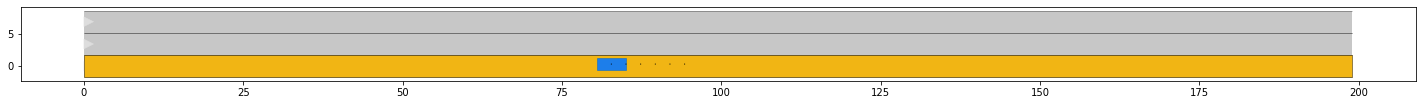

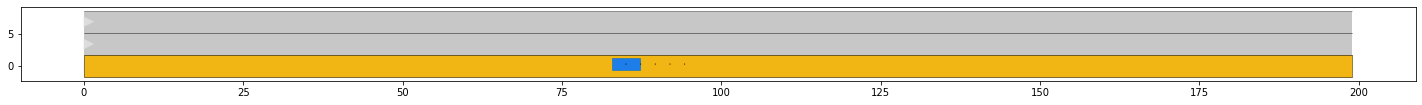

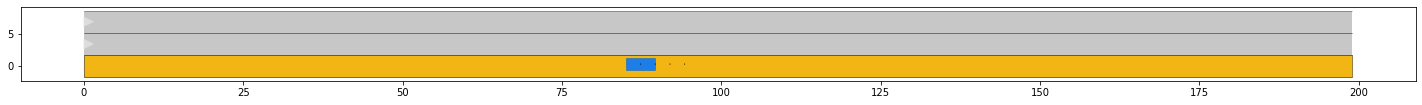

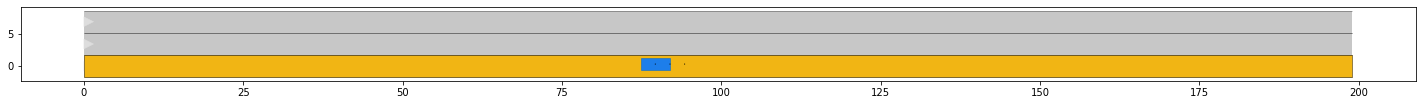

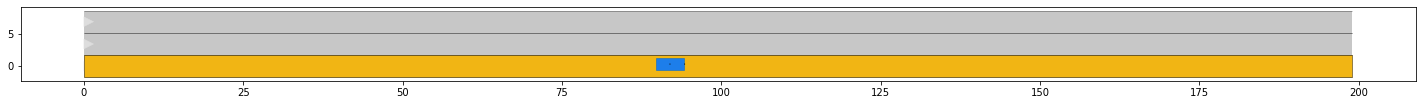

In [7]:
import os
import matplotlib.pyplot as plt
from IPython import display

# import functions to read xml file and visualize commonroad objects
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

# generate path of the file to be opened
file_path = "ZAM_Tutorial-1_1_T-1.xml"

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario for 40 time step, here each time step corresponds to 0.1 second
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    # plot the scenario at different time step
    scenario.draw(rnd, draw_params={'time_begin': i})
    # plot the planning problem set
    planning_problem_set.draw(rnd)
    rnd.render()

## 2. Modify XML file

It is possible to modify existing CommonRoad scenarios to costumize them to one's need. First, we would like to add a static obstacle to the scenario with the following specification:

    - obstacle type: parked vehicle
    - obstacle shape: rectangle, with a width of 2.0m and a length of 4.5m
    - initial state:
        - position: (30, 3.5) m
        - orientation: 0.02 rad
* obstacle id: since every object in the scenario must have a unique ID, we can use the member function **generate_object_id** of **Scenario** class to generate a unique ID for the object.

As documented in [StaticObstacle](https://commonroad-io.readthedocs.io/en/latest/api/scenario/#staticobstacle-class), we need to provide `obstacle_id, obstacle_type, obstacle_shape, initial_state` to construct a static obstacle.

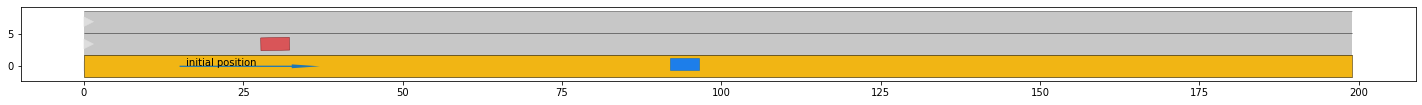

In [16]:
import numpy as np

# import necesary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import StaticObstacle, ObstacleType
from commonroad.scenario.trajectory import State

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# generate the static obstacle according to the specification, refer to API for details of input parameters
static_obstacle_id = scenario.generate_object_id()
static_obstacle_type = ObstacleType.PARKED_VEHICLE
static_obstacle_shape = Rectangle(width = 2.0, length = 4.5)
static_obstacle_initial_state = State(position = np.array([30.0, 3.5]), orientation = 0.02, time_step = 0)

# feed in the required components to construct a static obstacle
static_obstacle = StaticObstacle(static_obstacle_id, static_obstacle_type, static_obstacle_shape, static_obstacle_initial_state)

# add the static obstacle to the scenario
scenario.add_objects(static_obstacle)

# plot the scenario for each time step
for i in range(0, 41):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()

As can be seen, we have added a new static obstacle to the scenario. We can further add a dynamic obstacle with the following specifications:

    - obstacle type: car
    - obstacle shape: rectangle with a width of 1.8m and a length of 4.3m
    - initial state:
        - position: (50, 0.0) m
        - orientation: 0.00 rad
        - velocity: 22 m/s along x axis
    - we assume that the dynamic obstacle drives with constant velocity.

As documented in [DynamicObstacle](https://commonroad-io.readthedocs.io/en/latest/api/scenario/#dynamicobstacle-class), we need to pass in a **Prediction** object which in this case is a **TrajectoryPrediction** object. Its generation goes as follows:
    1. compute all subsequent states for the dynamic obstacle
    2. create a Trajectory from these states
    3. create a TrajectoryPrediction from this trajectory and obstacle shape

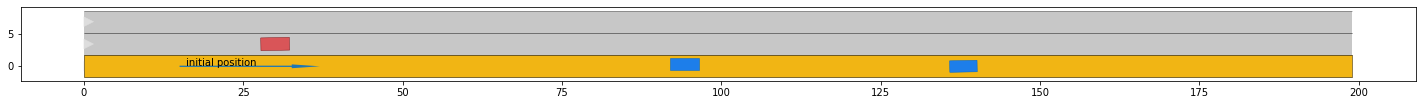

In [17]:
# import necesary classes from different modules
from commonroad.scenario.obstacle import DynamicObstacle
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

# initial state has a time step of 0
dynamic_obstacle_initial_state = State(position = np.array([50.0, 0.0]),
                                       velocity = 22,
                                       orientation = 0.02,
                                       time_step = 0)

# generate the states for the obstacle for time steps 1 to 40 by assuming constant velocity
state_list = []
for i in range(1, 41):
    # compute new position
    new_position = np.array([dynamic_obstacle_initial_state.position[0] + scenario.dt * i * 22, 0])
    # create new state
    new_state = State(position = new_position, velocity = 22,orientation = 0.02, time_step = i)
    # add new state to state_list
    state_list.append(new_state)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width = 1.8, length = 4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory, dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, 
                                   dynamic_obstacle_type, 
                                   dynamic_obstacle_shape, 
                                   dynamic_obstacle_initial_state, 
                                   dynamic_obstacle_prediction)

# add dynamic obstacle to the scenario
scenario.add_objects(dynamic_obstacle)

# plot the scenario for each time step
for i in range(0, 41):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()

## 3. Write XML file
After we have modified the scenario, we would like to save the changes and write the **Scenario** and **PlanningProblemSet** to a CommonRoad XML file. [CommonRoadFileWriter](https://commonroad-io.readthedocs.io/en/latest/api/common/#commonroadfilewriter-class) helps us with this purpse.
Note that we did not modify the **PlanningProblemSet** in this tutorial.

In [4]:
# import necesary classes from different modules
from commonroad.common.file_writer import CommonRoadFileWriter
from commonroad.common.file_writer import OverwriteExistingFile
from commonroad.scenario.scenario import Location
from commonroad.scenario.scenario import Tag

author = 'Max Mustermann'
affiliation = 'Technical University of Munich, Germany'
source = ''
tags = {Tag.CRITICAL, Tag.INTERSTATE}

# write new scenario
fw = CommonRoadFileWriter(scenario, planning_problem_set, author, affiliation, source, tags)

filename = "ZAM_Tutorial-1_2_T-1.xml"
fw.write_to_file(filename, OverwriteExistingFile.ALWAYS)

Replace file ZAM_Tutorial-1_2_T-1.xml


We can open our stored file again to check if everything is correct:

In [5]:
file_path = "ZAM_Tutorial-1_2_T-1.xml"

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    scenario.draw(rnd, draw_params={'time_begin': i})
    planning_problem_set.draw(rnd)
    rnd.render()